# The Training Process

## Establishing a Baseline

In [ ]:
dls = get_data(URLs.IMAGENETTE_160, 160, 128)

In [ ]:
def get_learner(**kwargs):
    return cnn_learner(dls, resnet34, pretrained=False,
                    metrics=accuracy, **kwargs).to_fp16()

epoch,train_loss,valid_loss,accuracy,time
0,2.571932,2.685040,0.322548,00:11
1,1.904674,1.852589,0.437452,00:11
2,1.586909,1.374908,0.594904,00:11


In [ ]:
learn = get_learner(opt_func=SGD)

(0.017378008365631102, 3.019951861915615e-07)

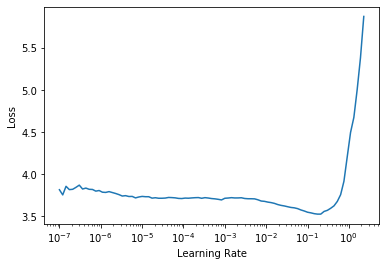

epoch,train_loss,valid_loss,accuracy,time
0,2.969412,2.214596,0.242038,00:09
1,2.442730,1.845950,0.362548,00:09
2,2.157159,1.741143,0.408917,00:09


## A Generic Optimizer

In [ ]:
def sgd_cb(p, lr, **kwargs): p.data.add_(-lr, p.grad.data)

In [ ]:
opt_func = partial(Optimizer, cbs=[sgd_cb])

epoch,train_loss,valid_loss,accuracy,time
0,2.730918,2.009971,0.332739,00:09
1,2.204893,1.747202,0.441529,00:09
2,1.875621,1.684515,0.445350,00:09


## Momentum

In [ ]:
def average_grad(p, mom, grad_avg=None, **kwargs):
    if grad_avg is None: grad_avg = torch.zeros_like(p.grad.data)
    return {'grad_avg': grad_avg*mom + p.grad.data}

In [ ]:
def momentum_step(p, lr, grad_avg, **kwargs): p.data.add_(-lr, grad_avg)

In [ ]:
opt_func = partial(Optimizer, cbs=[average_grad,momentum_step], mom=0.9)

epoch,train_loss,valid_loss,accuracy,time
0,2.856000,2.493429,0.246115,00:10
1,2.504205,2.463813,0.348280,00:10
2,2.187387,1.755670,0.418853,00:10


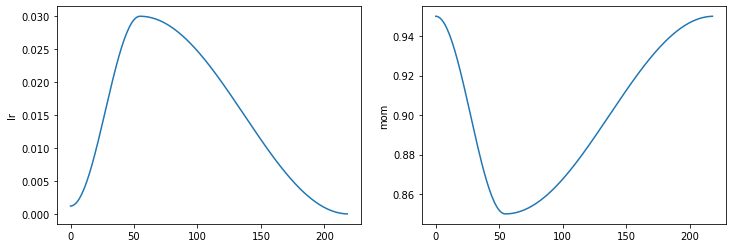

## RMSProp

In [ ]:
def average_sqr_grad(p, sqr_mom, sqr_avg=None, **kwargs):
    if sqr_avg is None: sqr_avg = torch.zeros_like(p.grad.data)
    return {'sqr_avg': sqr_mom*sqr_avg + (1-sqr_mom)*p.grad.data**2}

In [ ]:
def rms_prop_step(p, lr, sqr_avg, eps, grad_avg=None, **kwargs):
    denom = sqr_avg.sqrt().add_(eps)
    p.data.addcdiv_(-lr, p.grad, denom)

opt_func = partial(Optimizer, cbs=[average_sqr_grad,rms_prop_step],
                   sqr_mom=0.99, eps=1e-7)

epoch,train_loss,valid_loss,accuracy,time
0,2.766912,1.845900,0.402548,00:11
1,2.194586,1.510269,0.504459,00:11
2,1.869099,1.447939,0.544968,00:11


## Adam

## Decoupled Weight Decay

## Callbacks

### Creating a Callback

In [ ]:
class ModelResetter(Callback):
    def begin_train(self):    self.model.reset()
    def begin_validate(self): self.model.reset()

In [ ]:
class RNNRegularizer(Callback):
    def __init__(self, alpha=0., beta=0.): self.alpha,self.beta = alpha,beta

    def after_pred(self):
        self.raw_out,self.out = self.pred[1],self.pred[2]
        self.learn.pred = self.pred[0]

    def after_loss(self):
        if not self.training: return
        if self.alpha != 0.:
            self.learn.loss += self.alpha * self.out[-1].float().pow(2).mean()
        if self.beta != 0.:
            h = self.raw_out[-1]
            if len(h)>1:
                self.learn.loss += self.beta * (h[:,1:] - h[:,:-1]
                                               ).float().pow(2).mean()

### Callback Ordering and Exceptions

In [ ]:
class TerminateOnNaNCallback(Callback):
    run_before=Recorder
    def after_batch(self):
        if torch.isinf(self.loss) or torch.isnan(self.loss):
            raise CancelFitException

## Conclusion

## Questionnaire

1. What is the equation for a step of SGD, in math or code (as you prefer)?
1. What do we pass to `cnn_learner` to use a non-default optimizer?
1. What are optimizer callbacks?
1. What does `zero_grad` do in an optimizer?
1. What does `step` do in an optimizer? How is it implemented in the general optimizer?
1. Rewrite `sgd_cb` to use the `+=` operator, instead of `add_`.
1. What is "momentum"? Write out the equation.
1. What's a physical analogy for momentum? How does it apply in our model training settings?
1. What does a bigger value for momentum do to the gradients?
1. What are the default values of momentum for 1cycle training?
1. What is RMSProp? Write out the equation.
1. What do the squared values of the gradients indicate?
1. How does Adam differ from momentum and RMSProp?
1. Write out the equation for Adam.
1. Calculate the values of `unbias_avg` and `w.avg` for a few batches of dummy values.
1. What's the impact of having a high `eps` in Adam?
1. Read through the optimizer notebook in fastai's repo, and execute it.
1. In what situations do dynamic learning rate methods like Adam change the behavior of weight decay?
1. What are the four steps of a training loop?
1. Why is using callbacks better than writing a new training loop for each tweak you want to add?
1. What aspects of the design of fastai's callback system make it as flexible as copying and pasting bits of code?
1. How can you get the list of events available to you when writing a callback?
1. Write the `ModelResetter` callback (without peeking).
1. How can you access the necessary attributes of the training loop inside a callback? When can you use or not use the shortcuts that go with them?
1. How can a callback influence the control flow of the training loop?
1. Write the `TerminateOnNaN` callback (without peeking, if possible).
1. How do you make sure your callback runs after or before another callback?

### Further Research

1. Look up the "Rectified Adam" paper, implement it using the general optimizer framework, and try it out. Search for other recent optimizers that work well in practice, and pick one to implement.
1. Look at the mixed-precision callback with the documentation. Try to understand what each event and line of code does.
1. Implement your own version of the learning rate finder from scratch. Compare it with fastai's version.
1. Look at the source code of the callbacks that ship with fastai. See if you can find one that's similar to what you're looking to do, to get some inspiration.

## Foundations of Deep Learning: Wrap up

Congratulations, you have made it to the end of the "foundations of deep learning" section of the book! You now understand how all of fastai's applications and most important architectures are built, and the recommended ways to train them—and you have all the information you need to build these from scratch. While you probably won't need to create your own training loop, or batchnorm layer, for instance, knowing what is going on behind the scenes is very helpful for debugging, profiling, and deploying your solutions.

Since you understand the foundations of fastai's applications now, be sure to spend some time digging through the source notebooks and running and experimenting with parts of them. This will give you a better idea of how everything in fastai is developed.

In the next section, we will be looking even further under the covers: we'll explore how the actual forward and backward passes of a neural network are done, and we will see what tools are at our disposal to get better performance. We will then continue with a project that brings together all the material in the book, which we will use to build a tool for interpreting convolutional neural networks. Last but not least, we'll finish by building fastai's `Learner` class from scratch.